# Grad-CAM experiments

Contributions of different portions of images of restaurant interiors towards it being classified as either "crowded" or "empty". Original repo of network [here](https://github.com/dhth/restaurant-crowded-or-not).

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# !curl https://course-v3.fast.ai/setup/colab | bash

In [ ]:
# !apt-get -qq install ffmpeg
# restart kernel after install

In [ ]:
# DRIVE_BASE_PATH = "/content/gdrive/My\ Drive/Colab\ Notebooks/"

In [12]:
!ln -sf ../../utils utils

In [31]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from fastai import *
from fastai.vision import *

In [4]:
from fastai import version as fastai_version

In [5]:
print(f'fastai version -> {fastai_version.__version__}')

fastai version -> 1.0.33


In [15]:
bs = 32  #batch size

In [16]:
path = Path('../../../inf_test')

In [19]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [20]:
classes = ['crowded', 'empty']
data = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [21]:
learn = create_cnn(data, models.resnet34, pretrained=False)

In [22]:
learn.load('rest-saved-model1');

### Test images containing objects belonging to 2 classes

In [23]:
test_data ={
    "crowded": [
        "https://sokneanginhongkong.files.wordpress.com/2010/10/mcdonalds.jpg",
        "https://media-cdn.tripadvisor.com/media/photo-s/0b/42/22/21/kfc-restaurant-tables.jpg",
        "https://cdn-images-1.medium.com/max/1600/0*uYBMWc92tnTAbUnT.jpg"
        ],
                    
    "empty": [
        "https://media-cdn.tripadvisor.com/media/photo-s/10/0c/93/5e/starbucks-restaurants.jpg",
        "https://i2-prod.birminghammail.co.uk/incoming/article11694788.ece/ALTERNATES/s615/KFC-Martineau-Place-messy-tables-2.jpg",
        "https://s3-media2.fl.yelpcdn.com/bphoto/2nwyl5v1ywkCUNljUPPXwg/o.jpg"
        ]
}

In [59]:
def fetch_test_pics(image_dict, local_dir_name, data_classes):
    !mkdir -p {local_dir_name}

    for class_name in data_classes:
        for i, el in enumerate(image_dict[class_name]):
#             print(f'wget -q "{el}" -O {local_dir_name}/{class_name}_{i}.jpg')
            !wget -q "{el}" -O {local_dir_name}/{class_name}_{i}.jpg

    return Path(local_dir_name)

In [60]:
test_path = fetch_test_pics(tricky_pics, 'local_only_test_data', data.classes)

In [34]:
def see_test_files(test_dir_path):
    test_files = test_dir_path.ls()
    
    num_cols = 4
    num_rows = ceil(len(test_files)/num_cols)
    fig,ax = plt.subplots(num_rows,num_cols)
    fig.set_size_inches(num_cols*3,num_rows*3)

    for ind, ax in enumerate(ax.flat):
        if ind>=len(test_files):
            break   
            
        x = open_image(test_files[ind])
        xb,_ = data.one_item(x)
        xb_im = Image(data.denorm(xb)[0])
        xb_im.show(ax)
        title = test_files[ind].stem.split('_')[0]
        ax.set_title(title)
    
    fig.suptitle('Test images', fontsize=20)

    plt.show()

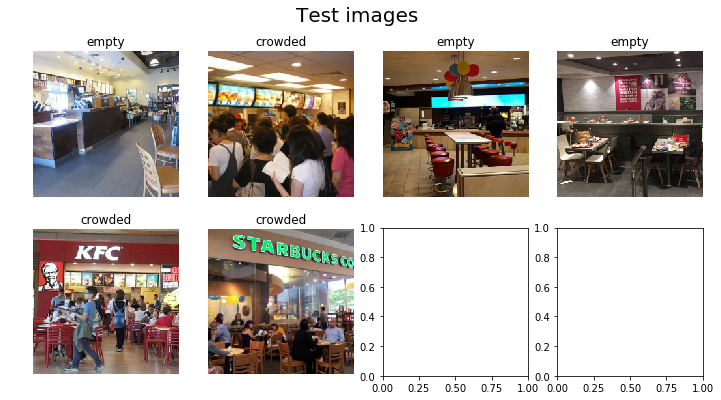

In [50]:
see_test_files(test_path)

In [36]:
from fastai.callbacks.hooks import *

In [37]:
m = learn.model.eval();

## Class-discriminative heat-maps along the network


In [38]:
def class_discriminative_activations(xb,cat):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [39]:
class_dict = {}
for i,el in enumerate(data.classes):
    class_dict[el.lower()] = i

In [40]:
def get_grad_cam_activations(xb, cat, relu=True):
    
    y = class_dict[cat]
    
    hooks_a,hooks_g = class_discriminative_activations(xb,y)
    
    acts = hooks_a.stored[0].cpu()
    grad = hooks_g.stored[0][0].cpu()

    grad_chan = grad.mean(1).mean(1)
    mult = (acts*grad_chan[...,None,None]).mean(0)

    if relu:
        mult = F.relu(mult)
            
    return mult

In [41]:
def plot_grad_cam_maps(img_paths):
    num_cols = len(data.classes)+1
    num_rows = len(img_paths)

    fig,ax = plt.subplots(num_rows,num_cols)
    fig.set_size_inches(num_cols*3,num_rows*3)
    
    ind = 0
    
    for i in range(num_rows):
        x = open_image(img_paths[i])
        xb,_ = data.one_item(x)
        xb_im = Image(data.denorm(xb)[0])
        xb = xb.cuda()
        pred = learn.predict(x)[0]
        xb_im.show(ax[i,0])
        ax[i,0].set_title(f'predicted: {pred}')
        for j in range(1,num_cols):
            if ind>=len(img_paths*3):
                break

            mult = get_grad_cam_activations(xb, data.classes[j-1])
            xb_im.show(ax[i,j])
            ax[i,j].imshow(mult, alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');
            ax[i,j].set_title(f'{data.classes[j-1]}')
            ind+=1

    fig.suptitle(f'Original/{" traits/".join(data.classes)} traits', fontsize=20)

The first column is the original images, the second highlights areas which contributed most towards "popular-cover" traits of the image, and the third towards the "rock-cover" traits.

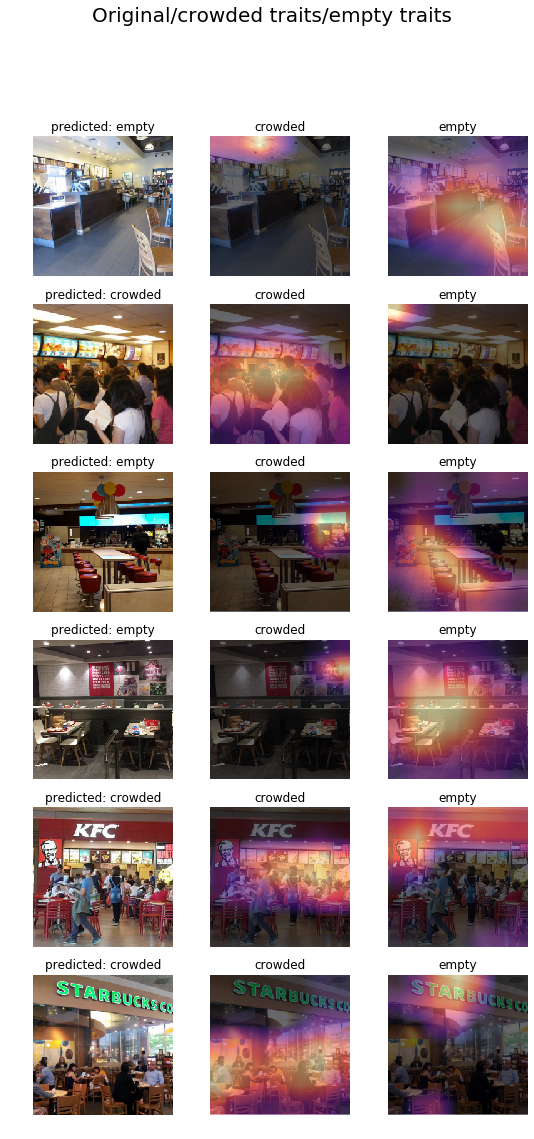

In [37]:
plot_grad_cam_maps(test_path.ls())

## Testing out on tricky pictures
Fetching some images that might be tricky for the model to classify. Also, some of these choices might be debatable.

In [54]:
tricky_pics ={
    "crowded": [
        "https://cdn-images-1.medium.com/max/1600/1*eQ85fuCVe70hIyCOZCzD3A.png",
        "https://untappedcities-wpengine.netdna-ssl.com/wp-content/uploads/2017/12/Discrete-Starbucks-Chelsea-NYC-Untapped-Cities3.jpg",
        "http://bamadining.ua.edu/wp-content/uploads/sites/5/2014/01/starbucks1.jpg"
        ],
                    
    "empty": [
        "https://steemitimages.com/p/o1AJ9qDyyJNSpZWhUgGYc3MngFqoAMzvqL3x4ggUtmWNVfvke?format=match&mode=fit",
        "https://steemitimages.com/p/o1AJ9qDyyJNSpZWhUgGYc3MngFqoAMgB3XhbQ681D4Jnfk6D4?format=match&mode=fit",
        "https://steemitimages.com/p/o1AJ9qDyyJNSpZWhUgGYc3MngFqoAMdcN5Khm3oW2yTxePvUv?format=match&mode=fit",
        "https://cdn.shopify.com/s/files/1/0606/2893/files/Starbucks3.jpg?15250892567421608680",
        "https://media-cdn.tripadvisor.com/media/photo-s/10/ec/2f/d6/restaurant-was-starting.jpg",
        "https://media-cdn.tripadvisor.com/media/photo-s/10/ec/2f/e4/an-empty-table-near-to.jpg",
        "https://www.themideastbeast.com/wp-content/uploads/2015/08/Subway-Restaurant-700x467.jpg",
        "https://thumbs.dreamstime.com/z/starbuck-s-queueing-customers-empty-stools-coffee-house-st-pancras-staion-london-34924334.jpg"
        ]
}

In [ ]:
tricky_pics_path = fetch_test_pics(tricky_pics, 'local_only_tricky_pics', data.classes)

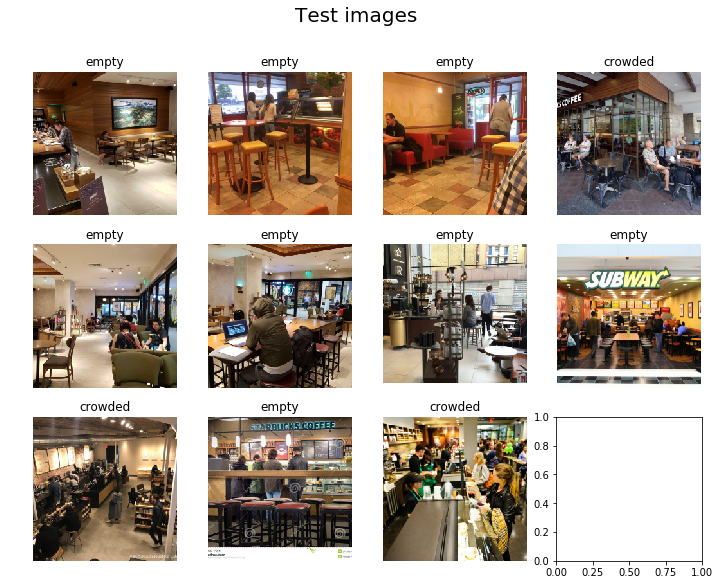

In [53]:
see_test_files(tricky_pics_path)

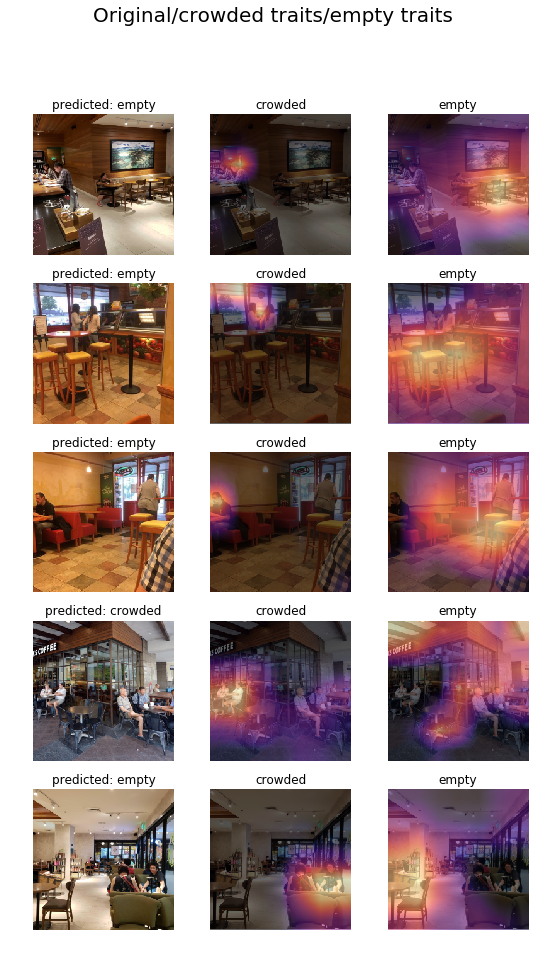

In [56]:
plot_grad_cam_maps(tricky_pics_path.ls()[:5])

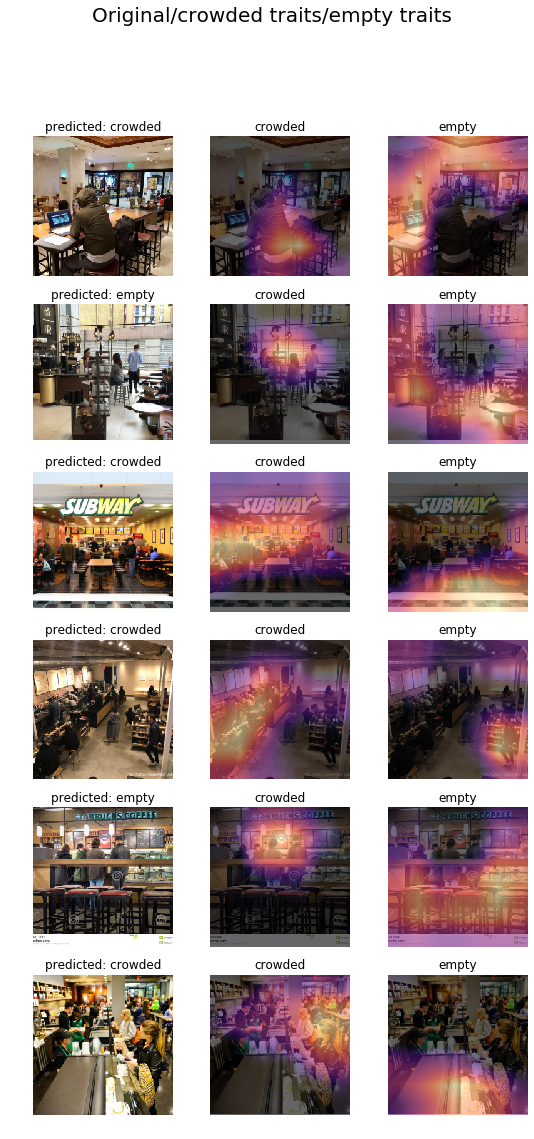

In [57]:
plot_grad_cam_maps(tricky_pics_path.ls()[5:])

As seen in the most of the pics, pixels containing people are contributing towards `crowded` scores, while pixels containing empty tables and chairs, floor, walls etc. are contributing towards `empty` scores. Pretty sweet.

## References:
- [Grad-CAM:
Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)
- [fastai's Deep Learning Part-1 (2018) MOOC](https://www.fast.ai/)